In [1]:
from GoogleAuth import gcp_API
from dateutil.parser import parser
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import googlemaps
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure, output_notebook
from bokeh.tile_providers import get_provider, Vendors

In [2]:
df14 = pd.read_csv('mass_shootings2014.csv', parse_dates=['Incident Date'])
df15 = pd.read_csv('mass_shootings2015.csv', parse_dates=['Incident Date'])
df16 = pd.read_csv('mass_shootings2016.csv', parse_dates=['Incident Date'])
df17 = pd.read_csv('mass_shootings2017.csv', parse_dates=['Incident Date'])
df18 = pd.read_csv('mass_shootings2018.csv', parse_dates=['Incident Date'])
df19 = pd.read_csv('mass_shootings2019.csv', parse_dates=['Incident Date'])

frames = [df19, df18, df17, df16, df15, df14]
df = pd.concat(frames, ignore_index=True, sort=True)
df.head()

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
0,3,1,8200 block of S Maryland Ave,Chicago,2019-08-25,NaN,NaN,Illinois
1,4,3,1700 block of East Bond St,Hobbs,2019-08-25,NaN,NaN,New Mexico
2,3,1,Warren Street,Lynn,2019-08-24,NaN,NaN,Massachusetts
3,7,0,6200 block of Maxwell Dr,Temple Hills (Camp Springs),2019-08-24,NaN,NaN,Maryland
4,2,3,4900 block of Southwind St,Houston,2019-08-23,NaN,NaN,Texas


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 8 columns):
# Injured         1942 non-null int64
# Killed          1942 non-null int64
Address           1938 non-null object
City Or County    1942 non-null object
Incident Date     1942 non-null datetime64[ns]
Incident ID       604 non-null float64
Operations        0 non-null float64
State             1942 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 121.5+ KB


In [4]:
df.describe(include='all')

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
count,1942.000000,1942.000000,1938,1942,1942,604.000000,0.0,1942
unique,NaN,NaN,1935,661,1125,NaN,NaN,46
top,NaN,NaN,2928 W Kentucky St,Chicago,2019-05-18 00:00:00,NaN,NaN,California
freq,NaN,NaN,2,141,7,NaN,NaN,220
first,NaN,NaN,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2019-08-25 00:00:00,NaN,NaN,NaN
mean,4.233780,1.122554,NaN,NaN,NaN,282212.294702,NaN,NaN
std,10.206065,2.449367,NaN,NaN,NaN,115965.298850,NaN,NaN
min,0.000000,0.000000,NaN,NaN,NaN,92194.000000,NaN,NaN
25%,3.000000,0.000000,NaN,NaN,NaN,168490.000000,NaN,NaN


In [29]:
df.sort_values(['# Killed', '# Injured'], ascending=False).head(20)

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
681,441,59,3950 Las Vegas Blvd S,Las Vegas,2017-10-01,NaN,NaN,Nevada
1202,53,50,1912 S Orange Ave,Orlando,2016-06-12,NaN,NaN,Florida
647,20,27,216 4th St,Sutherland Springs,2017-11-05,NaN,NaN,Texas
27,24,22,7101 Gateway Blvd,El Paso,2019-08-03,NaN,NaN,Texas
581,17,17,5901 Pine Island Rd,Pompano Beach (Parkland),2018-02-14,NaN,NaN,Florida
1356,19,16,1365 South Waterman Avenue,San Bernardino,2015-12-02,456893.0,NaN,California
125,4,13,2405 Courthouse Drive,Virginia Beach,2019-05-31,NaN,NaN,Virginia
302,2,13,99 Rolling Oaks Dr,Thousand Oaks,2018-11-07,NaN,NaN,California
314,7,11,5898 Wilkins Ave,Pittsburgh,2018-10-27,NaN,NaN,Pennsylvania
25,17,10,419 E 5th St,Dayton,2019-08-04,NaN,NaN,Ohio


In [30]:
df.sort_values(['# Injured', '# Killed'], ascending=False).head(20)

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State
681,441,59,3950 Las Vegas Blvd S,Las Vegas,2017-10-01,NaN,NaN,Nevada
1202,53,50,1912 S Orange Ave,Orlando,2016-06-12,NaN,NaN,Florida
776,25,0,220 W 6th St,Little Rock,2017-07-01,NaN,NaN,Arkansas
27,24,22,7101 Gateway Blvd,El Paso,2019-08-03,NaN,NaN,Texas
647,20,27,216 4th St,Sutherland Springs,2017-11-05,NaN,NaN,Texas
1356,19,16,1365 South Waterman Avenue,San Bernardino,2015-12-02,456893.0,NaN,California
1132,19,2,3580 Evans Ave,Fort Myers,2016-07-25,NaN,NaN,Florida
479,19,1,635 S Clinton Ave,Trenton,2018-06-17,NaN,NaN,New Jersey
1575,18,9,4671 S Jack Kultgen Fwy,Waco,2015-05-17,341622.0,NaN,Texas
581,17,17,5901 Pine Island Rd,Pompano Beach (Parkland),2018-02-14,NaN,NaN,Florida


In [37]:
df.loc[df['# Injured']>df['# Killed']].index.value_counts().sum()

1615

In [95]:
df[df.duplicated(['Address'], keep=False)]

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State,Full Address,Latitude,Longitude
360,4,0,NaN,Jacksonville,2018-09-09,NaN,NaN,Florida,NaN,37.225606,-95.716202
562,7,0,2928 W Kentucky St,Louisville,2018-03-17,NaN,NaN,Kentucky,"2928 W Kentucky St Louisville, Kentucky",38.243643,-85.802397
853,4,0,110 Calhoun Street,Vallejo,2017-04-16,NaN,NaN,California,"110 Calhoun Street Vallejo, California",38.120627,-122.266629
982,3,1,NaN,Clearlake Oaks,2016-12-01,NaN,NaN,California,NaN,37.225606,-95.716202
1353,3,1,2300 block of Baltimore Avenue,Cincinnati (Fairmount),2015-12-08,461476.0,NaN,Ohio,2300 block of Baltimore Avenue Cincinnati (Fai...,39.149724,-84.561468
1431,4,0,NaN,Berlin,2015-09-08,411888.0,NaN,Georgia,NaN,37.225606,-95.716202
1490,6,0,2928 W Kentucky St,Louisville,2015-07-19,377047.0,NaN,Kentucky,"2928 W Kentucky St Louisville, Kentucky",38.243643,-85.802397
1535,0,9,110 Calhoun Street,Charleston,2015-06-17,359830.0,NaN,South Carolina,"110 Calhoun Street Charleston, South Carolina",32.787511,-79.933094
1584,4,0,2300 block of Baltimore Avenue,Cincinnati,2015-05-07,335903.0,NaN,Ohio,"2300 block of Baltimore Avenue Cincinnati, Ohio",39.149724,-84.561468
1893,5,0,NaN,Starkville,2014-03-30,120621.0,NaN,Mississippi,NaN,37.225606,-95.716202


In [96]:
df[df.duplicated(['Address', 'City Or County'], keep=False)]

,# Injured,# Killed,Address,City Or County,Incident Date,Incident ID,Operations,State,Full Address,Latitude,Longitude
562,7,0,2928 W Kentucky St,Louisville,2018-03-17,NaN,NaN,Kentucky,"2928 W Kentucky St Louisville, Kentucky",38.243643,-85.802397
1490,6,0,2928 W Kentucky St,Louisville,2015-07-19,377047.0,NaN,Kentucky,"2928 W Kentucky St Louisville, Kentucky",38.243643,-85.802397


In [135]:
df.iat[1353,3]='Cincinnati'

In [6]:
sorted(df.State.unique().tolist())

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin']

In [39]:
cities_df = df.drop(df.columns[[2,4,5,6]], axis=1).groupby(['City Or County', 'State']).sum().sort_values(['# Injured', '# Killed'], ascending=False)
cities_df['# Incidents'] = df.drop(df.columns[[0,1,2,5,6]], axis=1).groupby(['City Or County', 'State']).count()
cities_df.head(50)

,,# Injured,# Killed,# Incidents
City Or County,State,,,
Chicago,Illinois,599,82,141
Las Vegas,Nevada,484,72,14
Philadelphia,Pennsylvania,180,29,43
New Orleans,Louisiana,167,30,35
Baltimore,Maryland,161,21,39
Memphis,Tennessee,153,19,37
Saint Louis,Missouri,143,42,41
Los Angeles,California,128,27,32
Washington,District of Columbia,126,10,30


In [40]:
cities_df.loc[['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island']]

,,# Injured,# Killed,# Incidents
City Or County,State,,,
Brooklyn,New York,106,7,23
Bronx,New York,43,2,9
Queens,New York,15,1,4
Manhattan,New York,4,0,1


In [42]:
df.drop(df.columns[[0,1,2,3,5,6]], axis=1).groupby('State').count().sort_values('Incident Date', ascending=False)

,Incident Date
State,
California,220
Illinois,194
Florida,133
Texas,121
Georgia,85
Pennsylvania,82
New York,82
Louisiana,78
Tennessee,74


In [67]:
yearly_df = df.groupby(df['Incident Date'].map(lambda x: x.year)).sum().drop(df.columns[[5,6,9,10]],axis=1)
yearly_df['# Incidents'] = df.groupby(df['Incident Date'].map(lambda x: x.year)).count().drop(df.columns[[0,1,2,3,5,6,7,8,9,10]],axis=1)
yearly_df

,# Injured,# Killed,# Incidents
Incident Date,,,
2014,1079,262,269
2015,1337,368,335
2016,1538,451,382
2017,1803,437,346
2018,1340,372,338
2019,1125,290,272


In [69]:
yearly_df.pct_change().round(5)*100

,# Injured,# Killed,# Incidents
Incident Date,,,
2014,NaN,NaN,NaN
2015,23.911,40.458,24.535
2016,15.034,22.554,14.030
2017,17.230,-3.104,-9.424
2018,-25.679,-14.874,-2.312
2019,-16.045,-22.043,-19.527


In [89]:
state_df = df.groupby([df['Incident Date'].map(lambda x: x.year), df['State']]).agg('count').drop(df.columns[[0,1,2,3,5,6,8,9,10]],axis=1)
group = state_df['Incident Date'].groupby(level=0, group_keys=False)
group.nlargest(10)

Incident Date  State       
2014           California      41
               Illinois        26
               Georgia         17
               Florida         16
               New York        14
               Texas           14
               Tennessee       13
               Louisiana       11
               Michigan        11
               Pennsylvania    10
2015           California      27
               Florida         25
               Illinois        25
               New York        21
               Georgia         20
               Texas           19
               Pennsylvania    15
               Louisiana       14
               Ohio            14
               Maryland        13
2016           California      46
               Illinois        42
               Texas           31
               Florida         30
               Georgia         17
               Alabama         15
               New York        15
               Louisiana       13
               Tenne

In [43]:
def get_geocode(address):
    gmaps = googlemaps.Client(key=gcp_API)
    geocode_result = gmaps.geocode(address)
    return geocode_result[0]['geometry']['location'].values() if geocode_result else (None, None)

In [44]:
df['Full Address'] = df['Address'] + ' ' + df['City Or County'] + ', ' + df['State'] if not df['Address'].empty else ''
test_df = df['Full Address'].map(lambda x: get_geocode(x) if x else None)
df['Latitude'] = test_df.map(lambda x: list(x)[0]).tolist()
df['Longitude'] = test_df.map(lambda x: list(x)[1]).tolist()

In [136]:
# df.to_csv('mass_shootings.csv', index=False)

In [230]:
output_notebook()

map_options = GMapOptions(lat=37.0625, lng=-95.677068, map_type="roadmap", zoom=3)

p = gmap(gcp_API, map_options, title="USA")

source = ColumnDataSource(
    data=dict(lat=df['Latitude'].tolist(),
              lon=df['Longitude'].tolist())
)

p.circle(x="lon", y="lat", size=8, fill_color="orange", fill_alpha=0.8, source=source)

show(p)


Loading BokehJS ...

In [173]:
chicago_df = df.loc[(df['City Or County']=='Chicago') & (df['State']=='Illinois')]
chicago_df['# Victims'] = chicago_df[['# Injured', '# Killed']].sum(axis=1)
chicago_df = chicago_df.drop(chicago_df.columns[[0,1,2,3,5,6,7]], axis=1).set_index('Incident Date')
chicago_df.loc[chicago_df.index.year==2014]

/Users/tzulungs/anaconda3/envs/sandbox-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Full Address,Latitude,Longitude,# Victims
Incident Date,,,,
2014-12-22,"5700 block of South Green Street Chicago, Illi...",41.790482,-87.646624,5
2014-11-19,"700 block of North St. Louis Avenue Chicago, I...",41.893646,-87.713804,4
2014-08-24,"8300 block of South Halsted Street Chicago, Il...",41.743211,-87.644335,4
2014-07-25,"700 South California Avenue Chicago, Illinois",41.872696,-87.696300,7
2014-07-19,"1300 North Mason Avenue Chicago, Illinois",41.903951,-87.774508,4
2014-07-11,"5200 West Quincy Street Chicago, Illinois",41.877689,-87.755419,4
2014-06-04,"4900 West West End Avenue Chicago, Illinois",41.883270,-87.748186,4
2014-06-02,"2660 E. 79th St Chicago, Illinois",41.752129,-87.559112,7
2014-06-01,West Ferdinand Street and North Lavergne Avenu...,41.889518,-87.750493,6


In [206]:
def mercator(latitude, longitude):
    xlist, ylist = [], []
    r_major = 6378137.000
    for lat, lon in zip(latitude, longitude):
        x = r_major * math.radians(lon)
        scale = x/lon
        y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
            lat * (math.pi/180.0)/2.0)) * scale
        xlist.append(x)
        ylist.append(y)
    return (xlist, ylist)

In [208]:
latitude, longitude = chicago_df['Latitude'].tolist(), chicago_df['Longitude'].tolist()
chicago_df['X Coordinate'], chicago_df['Y Coordinate'] = mercator(latitude, longitude)
chicago_df.head()

,Full Address,Latitude,Longitude,# Victims,X Coordinate,Y Coordinate
Incident Date,,,,,,
2019-08-25,"8200 block of S Maryland Ave Chicago, Illinois",41.745601,-87.604151,4,-9.752049e+06,5.122948e+06
2019-08-11,"3500 block of W Lake St Chicago, Illinois",41.884970,-87.713740,6,-9.764249e+06,5.143764e+06
2019-08-09,"7300 block of S Artesian Ave Chicago, Illinois",41.760893,-87.684635,4,-9.761009e+06,5.125229e+06
2019-08-04,"1800 S Kildare Ave Chicago, Illinois",41.856916,-87.732577,8,-9.766346e+06,5.139570e+06
2019-08-04,"2900 block of W Roosevelt Rd Chicago, Illinois",41.866775,-87.698502,7,-9.762553e+06,5.141044e+06


In [229]:
output_notebook()
p = figure(x_range=(-9765000, -9745000), y_range=(5105000, 5173000),
           x_axis_type='mercator', y_axis_type='mercator')

tile_provider = get_provider(Vendors.CARTODBPOSITRON)
p.add_tile(tile_provider)

years = chicago_df.index.year.unique().tolist()[::-1]
colors = ['green', 'orange', 'red', 'purple', 'blue', 'pink']

for year, color in zip(years, colors):
    p.circle(x=chicago_df.loc[chicago_df.index.year==year]['X Coordinate'],
             y=chicago_df.loc[chicago_df.index.year==year]['Y Coordinate'],
             size=(chicago_df.loc[chicago_df.index.year==year]['# Victims']*3).tolist(),
             legend=f'{year} Shootings', line_color=color, fill_color=color, fill_alpha=0.3)

show(p)

Loading BokehJS ...

In [231]:
df = df.drop('Operations', axis=1)
df['# Victims'] = df.loc[:, ['# Injured', '# Killed']].sum(axis=1)
df.sort_values(['Incident Date', 'State'], inplace=True)
df['Cumulative Victims Same Year'] = df.groupby(df['Incident Date'].map(lambda x: x.year))['# Victims'].apply(lambda x: x.cumsum())
df.set_index('Incident Date', inplace=True)

In [295]:
ts_df = df.drop(['Address', 'City Or County', 'Incident ID', 'State', 'Latitude', 'Longitude'], axis=1)
ts_df = ts_df.resample('W').sum().drop('Cumulative Victims Same Year', axis=1)
ts_df.index.rename('Week Ending In', inplace=True)
ts_df['Cumulative Victims Same Year'] = ts_df.groupby(ts_df.index.map(lambda x: x.year))['# Victims'].apply(lambda x: x.cumsum())
ts_df['Year'], ts_df['Week #'] = ts_df.index.year, ts_df.index.week

In [296]:
ts_df

,# Injured,# Killed,# Victims,Cumulative Victims Same Year,Year,Week #
Week Ending In,,,,,,
2014-01-05,8,4,12,12,2014,1
2014-01-12,20,0,20,32,2014,2
2014-01-19,13,7,20,52,2014,3
2014-01-26,15,3,18,70,2014,4
2014-02-02,8,1,9,79,2014,5
2014-02-09,14,4,18,97,2014,6
2014-02-16,42,6,48,145,2014,7
2014-02-23,6,8,14,159,2014,8
2014-03-02,9,6,15,174,2014,9


In [298]:
ts_df.loc[ts_df['Year']==y, :]

,# Injured,# Killed,# Victims,Cumulative Victims Same Year,Year,Week #
Week Ending In,,,,,,
2015-01-04,18,6,24,24,2015,1
2015-01-11,24,12,36,60,2015,2
2015-01-18,7,2,9,69,2015,3
2015-01-25,20,10,30,99,2015,4
2015-02-01,16,7,23,122,2015,5
2015-02-08,15,9,24,146,2015,6
2015-02-15,6,3,9,155,2015,7
2015-02-22,14,8,22,177,2015,8
2015-03-01,18,13,31,208,2015,9


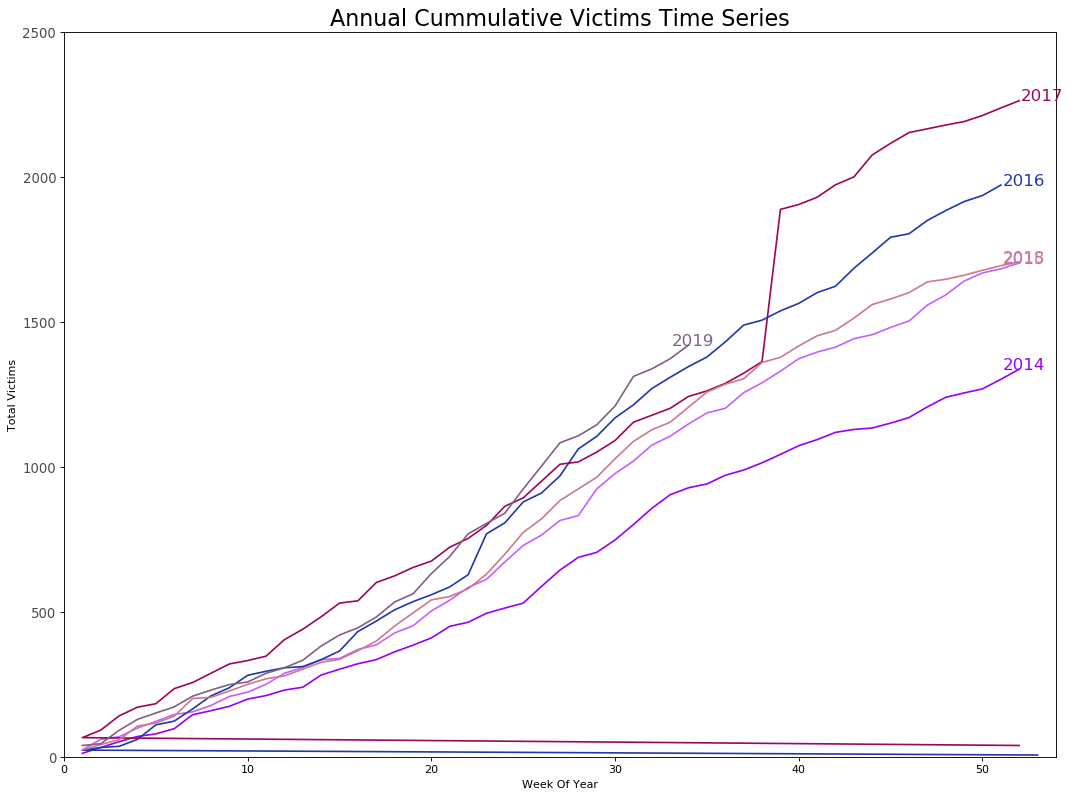

In [315]:
years = ts_df['Year'].unique().tolist()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):        
    plt.plot('Week #', 'Cumulative Victims Same Year', data=ts_df.drop(ts_df.columns[[0,1,2]], axis=1).loc[ts_df['Year']==y, :], color=mycolors[i], label=y)
    plt.text(ts_df.loc[ts_df['Year']==y, :].shape[0]-.9, ts_df.loc[ts_df['Year']==y, 'Cumulative Victims Same Year'][-1:].values[0], y, fontsize=15, color=mycolors[i])

plt.gca().set(xlim=(0, 54), ylim=(0, 2500), ylabel='Total Victims', xlabel='Week Of Year')
plt.title("Annual Cummulative Victims Time Series", fontsize=20)
plt.show()

In [126]:
gmaps = googlemaps.Client(key=gcp_API)
geocode_result = gmaps.geocode('Starkville, Mississippi')
geocode_result

[{'address_components': [{'long_name': 'Starkville',
    'short_name': 'Starkville',
    'types': ['locality', 'political']},
   {'long_name': 'Oktibbeha County',
    'short_name': 'Oktibbeha County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Mississippi',
    'short_name': 'MS',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '39759', 'short_name': '39759', 'types': ['postal_code']}],
  'formatted_address': 'Starkville, MS 39759, USA',
  'geometry': {'bounds': {'northeast': {'lat': 33.5062939, 'lng': -88.788859},
    'southwest': {'lat': 33.406288, 'lng': -88.87558609999999}},
   'location': {'lat': 33.4503998, 'lng': -88.81838719999999},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 33.5062939, 'lng': -88.788859},
    'southwest': {'lat': 33.406288, 'lng': -88.87558609999999}}},
  'place_id': 'ChIJ

In [127]:
lat, lng = geocode_result[0]['geometry']['location'].values()

In [128]:
lat

33.4503998

In [129]:
lng

-88.81838719999999

In [132]:
df.iloc[1893]

# Injured                           5
# Killed                            0
Address                           NaN
City Or County             Starkville
Incident Date     2014-03-30 00:00:00
Incident ID                    120621
Operations                        NaN
State                     Mississippi
Full Address                      NaN
Latitude                      33.4504
Longitude                    -88.8184
Name: 1893, dtype: object

In [48]:
output_file("gmap.html")

map_options = GMapOptions(lat=37.0625, lng=-95.677068, map_type="roadmap", zoom=3)

p = gmap(gcp_API, map_options, title="USA")

source = ColumnDataSource(
    data=dict(lat=df['Latitude'].tolist(),
              lon=df['Longitude'].tolist())
)

p.circle(x="lon", y="lat", size=8, fill_color="blue", fill_alpha=0.8, source=source)

show(p)
